<a href="https://colab.research.google.com/github/Petrichoeur/Neural_Net_from_scratch/blob/master/Keras_handmade_utils/Preprocess_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#keras.backend.bias_add(x, bias, data_format=None)

In [2]:
from keras import backend as K # Backend import to make a custom activation function later  
from keras.models import Model ,Sequential
from matplotlib import pyplot as plt
from keras.layers import Dense, Input, Concatenate, Lambda
import pandas as pd 
import numpy as np   

from sklearn.model_selection import train_test_split
from sklearn import datasets 
from sklearn.preprocessing import OneHotEncoder
import warnings 
from keras.utils import plot_model
warnings.filterwarnings("ignore")  # A lot of Depreciating warning with tensorflow .. 


from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log')   
# For tensorboard use later 

Using TensorFlow backend.


For the purpose of this notebook i will use a dataset that i find interesting and that you can find on this github repo : 
 https://github.com/Bhush98/Predicting-pulsar-star   
 It's  a simple binary classification problem

 But don't focus on the dataset, focus on the preprocessing !! 


# Import iris dataset for later 

In [0]:
# Let's use the classical iris dataset : 
iris = datasets.load_iris()
X = iris.data
y = iris.target.reshape(-1, 1) 
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(y)

# Preprocessing inside the network 

## Normalization

 What i want to do here is make the normalization ( often made with the MinMaxScaler() of Sklearn ) part ot a neural network made with Keras. The purpose is to not re-use the scaler you use each time you want to reuse your model . 
 But this imply the same limitation met with a simple standardisation or normalization : We hope that all the max and min values of each features are represented in the training data set .  

 First, we have to understand how normalization work : 
 For a given feature , we will call it  $X_f$ ,   the normalization of each element  $ x \in X_f$ is  : 

 $$ Normalize(x) =\frac{x-min(X_f)}{max(X_f)-min(X_f)} $$  

 Now we have to think, how can we use this in a neuron in a neural network ?  we have to analyse the structure of a neuron , we have a weights ( which can be fixed ) and an activation function ( which can be a simple linear function) .  
So if we make a 1:1 connection beetween each features of the inputs and a simple neurone , we can assign a normalization . 
in our case : 

 $$ Normalize(x) =$$ $$  x * \frac{1}{max(X_f)-min(X_f)} - \frac{min(X_f)}{max(X_f)-min(X_f)} $$  $$=$$ $$ a*x + b $$  

 We just have to fix the weights at 1 ( identity ) and make ax+b to the activation function .  



## Making the activation function 

In [0]:
# We use the keras back end functions to make it compatible with the architecture of an NN on Keras .  
# K.constant(value, dtype=None, shape=None, name=None)
def normalization(x,a,b):  
    return (K.identity(x)*a) - b 

In [0]:
# Okay so , simple right ? Unfortunately, it's not that simple . Because an activation function in Keras must have only one argument
# in the api . You can use hand_made layer to solve the issue but it's harder and it's a MacGyver Technique . 
# I WANT an activation function , so , it's a bit brutal but : we can define a function within a function . 
def normalization(mini,maxi):   
    a = 1 / (maxi-mini) 
    b= -a*mini
    def inception(x) :
        return (K.identity(x)*a) + b   
    return inception 


In [6]:
# So let's make a Tensor  and try this function .
x= np.array([8]) # a simple 1d array
var = K.variable(value=x, dtype='float64')  # Transform the array into tensorflow variable, a tensor .
K.eval(normalization(1,2)(var) )  # I evaluate the result of the function .

array([7.])

In [0]:
# That was the easy part , now we want to make the 1:1 layers from the inputs . 
# I'll use the architecture of a simple MLP. 
def Normalization_layer(X,input_name='Input1',output_name='output1'):   
    # X must be an numpy array 
    num_input = X.shape[1]  


    #We will collect the min and max of each values : 
    mini ={} 
    maxi = {} 
    for i in range(num_input): 
        mini[i]=min(X[:,i]) 
        maxi[i]=max(X[:,i])



    input_neural=  Input([num_input],name=input_name)
    # We will use the Lambda functionnality of Keras for spliting the input into 
    #  different input layer. 
    store_direct = {} 
    for i in range(num_input):
        store_direct[i] = Lambda(lambda x: x[:,i:i+1], output_shape=(1,))(input_neural) 
    # we connect each element to a single neuron : 
    for i in range(num_input): 
        store_direct[i] = Dense(1,  
                                use_bias=False,  
                                input_shape=(1,) ,
                                kernel_initializer='one',
                                trainable=False ,
                                activation=normalization(mini[i],maxi[i]))(store_direct[i])  
    # trainable = False, because i don't want to be part of the backpropagation , it's just preprocessing 
    # use_bias = False : obviously we don't neet a bias  
    # kernel_initializer='one' , to set all the weights at 1 . 
    output_preprocess = Concatenate(name=output_name)([val for val in store_direct.values()]) # I concatenate all for getting the output  
    # I return the input and the output , to be used in a keras model.  

    return Model(input_neural,output_preprocess)




So our function return a model , that we can add later to a simple model made with Sequential() method in Keras 

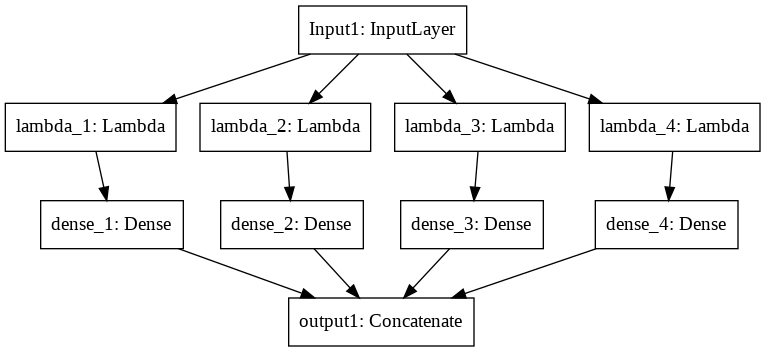

In [8]:
# Let's see what the Normalization_layer looks like : 
Norm = Normalization_layer(X)
plot_model(Norm)

# Finaly make the model !

In [9]:
# Let's make a simple model for  a  classification  with 3 labels...for the iris dataset for example 
model = Sequential() 
model.add(Norm) 
model.add(Dense(10, input_shape=(4,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax', name='output')) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4)                 4         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 197
Trainable params: 193
Non-trainable params: 4
_________________________________________________________________


In [0]:
# Let's make a train and a validation set first  = 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 108 samples, validate on 12 samples


Epoch 1/10
108/108 [==============================] - 0s 4ms/step - loss: 1.1291 - acc: 0.4537 - val_loss: 1.1763 - val_acc: 0.4167

Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 1.0492 - acc: 0.6204 - val_loss: 1.0892 - val_acc: 0.3333
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.9644 - acc: 0.5833 - val_loss: 0.9858 - val_acc: 0.3333
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.8687 - acc: 0.5833 - val_loss: 0.8903 - val_acc: 0.3333
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.7784 - acc: 0.5926 - val_loss: 0.7977 - val_acc: 0.3333
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.6809 - acc: 0.6574 - val_loss: 0.6614 - val_acc: 1.0000
Epoch 7/10
108/108 [==============================] - 0s 1ms/ste

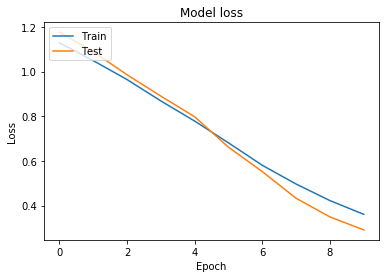

In [12]:



history = model.fit(X_train, y_train,
          batch_size=1,
          epochs=10,
          verbose=1,
          validation_split=0.1,
          callbacks=[tbCallBack])  
# You can find this example for the vizualisation here : https://keras.io/visualization/

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# Let's see how well trained our model is  ! 
pred=model.predict(X_test)  
predict_class = np.argmax(pred, axis=1)
predict_class = predict_class.tolist()
from sklearn.metrics import classification_report 
print(classification_report(np.round(pred),y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.92      1.00      0.96        11
           2       1.00      0.89      0.94         9

   micro avg       0.97      0.97      0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30
 samples avg       0.97      0.97      0.97        30



This notebook is not about how well a multi layer perceptron can handle a classification but it's about creating an entire model without a preprocessing part out of it . With this method of normalization you can juste save the model with keras and you don't have to save a Scaler with pickle or joblib. it makes your model easier to put into production

# Bonus  ( TENSORBOARD ) 
Click on the last link  after the execution of the code below to be redirected to tensorboard

In [14]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip 

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &') 

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])" 

# Thanks to : https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

--2020-01-30 01:24:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.119.24, 52.54.249.116, 34.230.145.192, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.119.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  39.8MB/s    in 0.3s    

2020-01-30 01:24:39 (39.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://bdc0c628.ngrok.io
